In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import random as rn

seed = 0 # Here sd means seed.
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jorge/anaconda3/

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from tensorflow.keras import initializers

from keras.callbacks import EarlyStopping

 

#from tensorflow.keras.layers import Attention
#from attention_decoder import AttentionDecoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import max_error
import seaborn as sns
from keras.callbacks import History 
from sklearn.model_selection import KFold 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit

In [4]:
path = os.getcwd()
folder = path+"/dataset/ts_jorge2/"
print(folder)

/home/jorge/tsunami-warning/dataset/ts_jorge2/


In [5]:
df_x = pd.read_json(folder+'DataFrame_boya-41-L0.json') # cargar dataframe
df_y = pd.read_json(folder+'DataFrame_boya-22-L0.json') # cargar dataframe

In [6]:
index = pd.date_range('25/8/2020', periods=len(df_x), freq='10S')
Datetime = pd.DataFrame({'Datetime':index})

In [7]:
df_x = pd.concat([Datetime, df_x], axis=1,)
df_y = pd.concat([Datetime, df_y], axis=1,)

Text(0, 0.5, 'Altura de ola [m]')

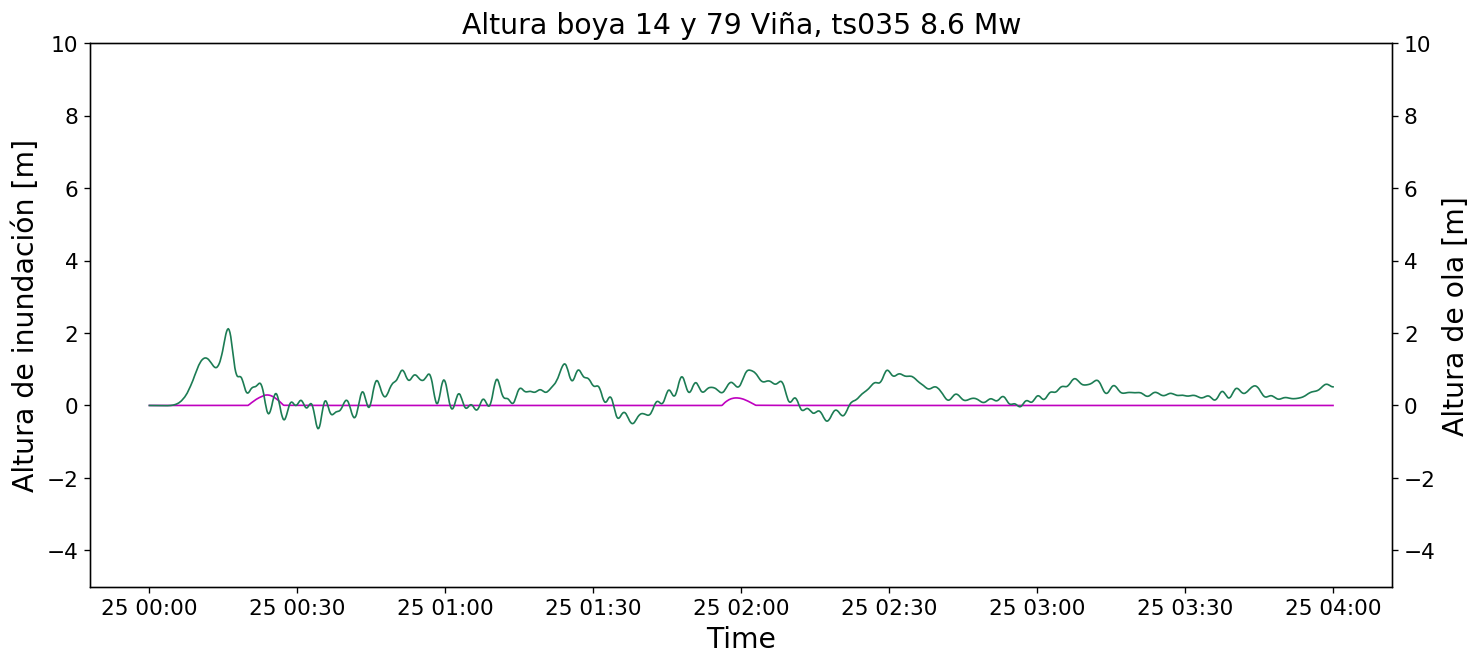

In [8]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['Datetime'],df_y['boyas22_000035'], color='m', linewidth=1.0)
plt.ylim(-5,10)
plt.twinx()
plt.plot(df_x['Datetime'],df_x['boyas41_000035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-5,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

Text(0, 0.5, 'Altura de ola [m]')

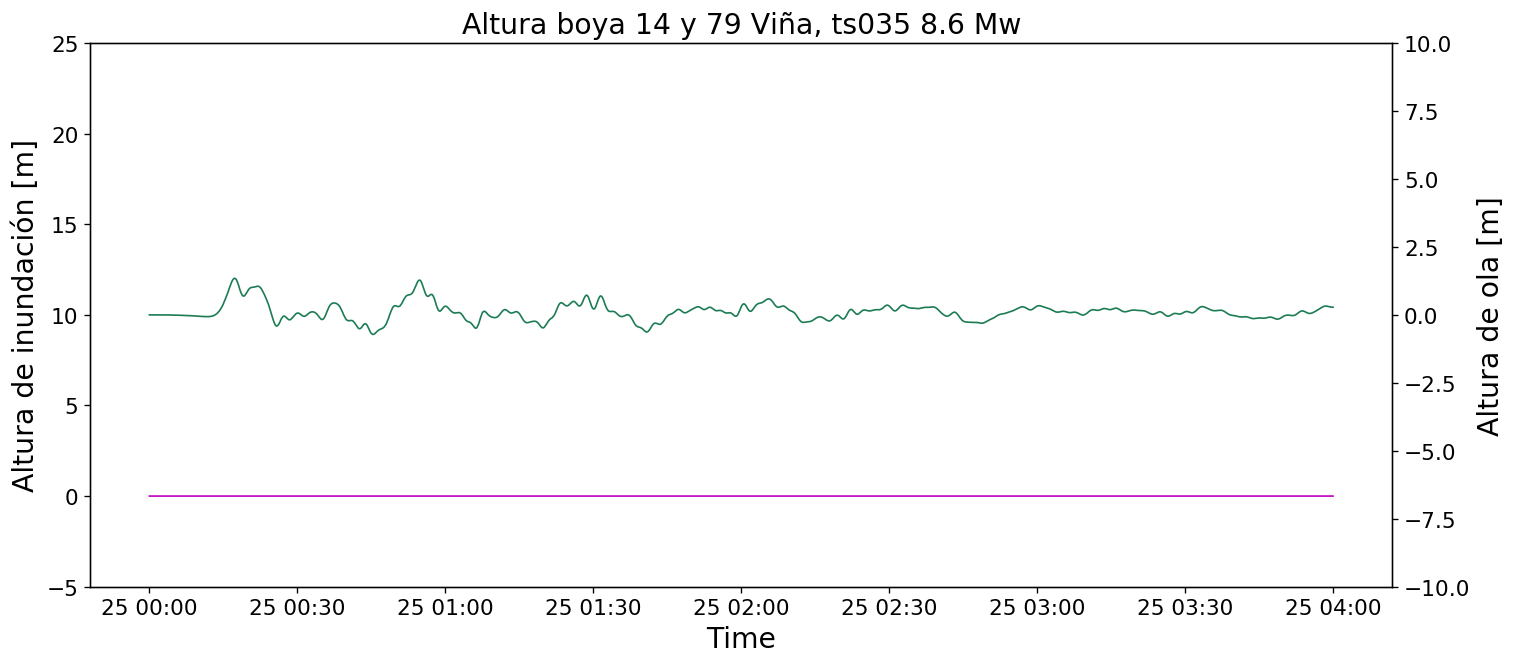

In [9]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['Datetime'],df_y['boyas22_000126'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df_x['Datetime'],df_x['boyas41_000126'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

## Generación de Grupos (Inunda- No Inunda)

In [10]:
indexC = df_y.columns
len(indexC)

350

In [11]:
indexC

Index(['Datetime', 'boyas22_000000', 'boyas22_000001', 'boyas22_000002',
       'boyas22_000003', 'boyas22_000004', 'boyas22_000005', 'boyas22_000006',
       'boyas22_000007', 'boyas22_000008',
       ...
       'boyas22_000340', 'boyas22_000341', 'boyas22_000342', 'boyas22_000343',
       'boyas22_000344', 'boyas22_000345', 'boyas22_000346', 'boyas22_000347',
       'boyas22_000348', 'boyas22_000349'],
      dtype='object', length=350)

In [12]:
Inu = []
inu = {}
NoInu = []
c = -1
groups = []
for i in indexC:
    if i.startswith("boyas22"):
        c+=1
        if df_y[i].max()>0:
            groups.append(1)
            Inu.append(c)
            inu[i] = [df_y[i].max()]
        else:
            NoInu.append(c)
            groups.append(0)

In [13]:
df_x = df_x.loc[0:180*2]# solo la primera 0.5 hora de registro
df_y = df_y.loc[0:180*2]# solo la primera 0.5 hora de registro

In [14]:
df_x.describe()

,boyas41_000000,boyas41_000001,boyas41_000002,boyas41_000003,boyas41_000004,boyas41_000005,boyas41_000006,boyas41_000007,boyas41_000008,boyas41_000009,...,boyas41_000340,boyas41_000341,boyas41_000342,boyas41_000343,boyas41_000344,boyas41_000345,boyas41_000346,boyas41_000347,boyas41_000348,boyas41_000349
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,...,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,-0.014071,0.113835,-0.152811,0.062005,0.054940,0.105730,0.075315,-0.328846,0.035221,-0.135921,...,0.234707,-2.585636,-0.306780,-0.871478,-2.771273,-1.977692,-1.972114,-0.573523,-0.398737,-1.546063
std,0.116763,0.330457,0.524716,0.134819,0.053937,0.377988,0.111725,0.298663,0.121006,0.310860,...,0.851794,1.617038,0.539877,1.436171,1.340957,1.039488,1.645784,1.287773,0.679098,1.579582
min,-0.259964,-0.473192,-1.145839,-0.222348,-0.001820,-0.848628,-0.146178,-0.762087,-0.151560,-0.729909,...,-1.866970,-5.275052,-1.445994,-3.339396,-4.998715,-4.314883,-4.430202,-3.404433,-2.349685,-5.253216
25%,-0.079911,-0.102786,-0.604036,0.000246,-0.000193,-0.075592,-0.000382,-0.657322,-0.057974,-0.359734,...,-0.244478,-3.988360,-0.769585,-2.211231,-3.840200,-2.676772,-3.565088,-1.911430,-0.898904,-2.901030
50%,-0.000876,0.012074,-0.214722,0.022119,0.047476,0.066179,0.011633,-0.310380,0.005433,-0.142241,...,0.045770,-2.570984,-0.371665,-0.746593,-2.762356,-2.158738,-1.931714,-0.273140,-0.238337,-1.346550
75%,0.055179,0.290676,0.353490,0.186701,0.100102,0.242557,0.191266,-0.042557,0.085099,0.099595,...,0.521232,-1.380549,0.190689,0.279880,-1.919520,-1.176883,-0.523906,0.206413,0.087143,-0.075112
max,0.231059,0.936466,0.700394,0.304961,0.169986,1.466795,0.265524,0.114877,0.308145,0.467492,...,3.151909,0.179390,0.488516,1.801357,0.000000,0.000000,0.690342,2.128556,1.209068,0.562347


In [15]:
df_x = df_x.resample('10S', on='Datetime').mean()
df_y = df_y.resample('10S', on='Datetime').mean()

Text(0, 0.5, 'Altura de ola [m]')

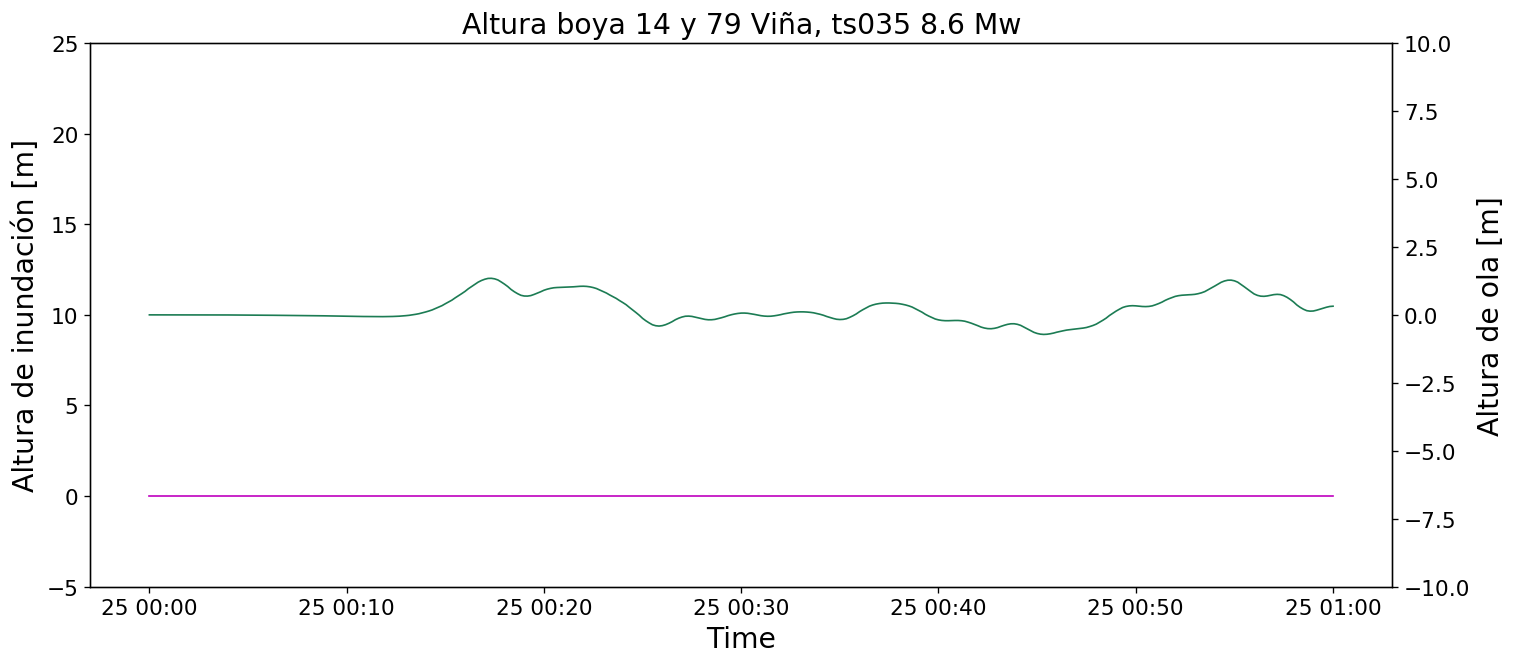

In [16]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['boyas22_000126'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df_x['boyas41_000126'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [17]:
df_x = df_x.resample('T').max()
df_y = df_y.resample('T').max()

Text(0, 0.5, 'Altura de ola [m]')

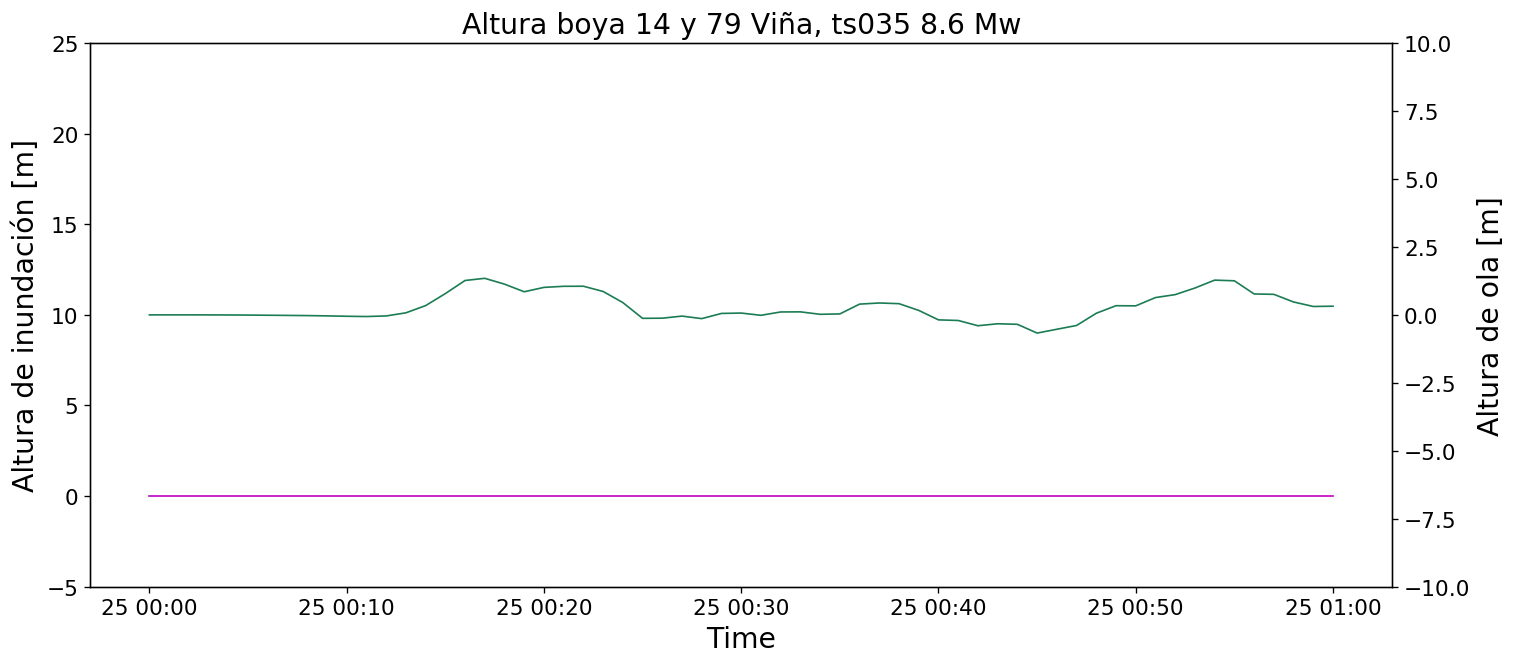

In [18]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['boyas22_000126'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df_x['boyas41_000126'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [19]:
print('Escenarios que inundan',len(Inu))
print('Escenarios que no inundan',len(NoInu))

Escenarios que inundan 158
Escenarios que no inundan 191


In [20]:
df_x = df_x.values.astype('float32')
df_y = df_y.values.astype('float32')

In [21]:
#data_pre_train, data_pre_temp = train_test_split(data, test_size= 0.5)
#data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

#scaler = StandardScaler().fit(df)
#df= scaler.transform(df)
#df= pd.DataFrame(scaler.transform(df),
 #                                columns=df.columns)


In [22]:
#xtest = df.pop('boyas14_ts035') # asigna y quita columna
#ytest = df.pop('boyas101_000126') # asigna y quita columna

In [23]:
#df = df.values.astype('float32')
#xtest = xtest.values.astype('float32')
#ytest = ytest.values.astype('float32')

In [24]:
# genera secuencias de entrada y salida
def split_sequence(df):
    X = list()
    for time in range(0,df.shape[1],1):
        # se suma uno porque no considera el ultimo
        seq_x = df[:,time]
        X.append(seq_x)
        
    return np.array(X)


In [25]:
trainX = split_sequence(df_x)
trainY = split_sequence(df_y)
#testX,testY = xtest,ytest

In [26]:
trainY.shape

(349, 61)

In [27]:
n_features = 1
n_steps = trainX.shape[1]
print('n_steps :',n_steps)

n_steps : 61


In [28]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))


In [29]:
trainX.shape

(349, 61, 1)

In [30]:
trainY.shape

(349, 61)

**comentario :** Etiquetas para diferencias las escenarios que **Si inundan** y los que **No indundan**, debido a lo desbalanceada que esta la data aproximadamente solo el 18% de los escenarios inundan. 

## Train-Validation-Test.
Separar datos de forma balanceda.

In [31]:
from sklearn.model_selection import train_test_split
SiInu_id = []
NoInu_id = []
cont = -1
for i in groups:
    cont+=1
    if i ==0:
        NoInu_id.append(cont)
        
    if i ==1:
        SiInu_id.append(cont)

y_train, y_val = train_test_split(SiInu_id, test_size=0.3, random_state=42)
x_train, x_val = train_test_split(NoInu_id, test_size=0.3, random_state=42)

y_val, y_test = train_test_split(y_val, test_size=0.33, random_state=42)
x_val, x_test = train_test_split(x_val, test_size=0.33, random_state=42)

x_train+=y_train
x_val+=y_val
x_test+=y_test

np.random.shuffle(x_train) # indices de train balanceados y desordenados
np.random.shuffle(x_val) # indices de validation balanceados y desordenados
np.random.shuffle(x_test) # indices de validation balanceados y desordenados

In [32]:
total = len(groups)


In [33]:
print('% Datos de train: ',len(x_train)/total)
print('% Datos de validation: ',len(x_val)/total)
print('% Datos de test: ',len(x_test)/total)

% Datos de train:  0.6962750716332379
% Datos de validation:  0.20057306590257878
% Datos de test:  0.10315186246418338


## CNN 1-D.

In [34]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40)

In [35]:

import time

epoch = 1000
Xm = trainX
ym = trainY

hist = History()
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9,#kernel_initializer=initializer, bias_initializer=bias_ini,
                 activation='relu', input_shape=(n_steps, n_features)))
model.add(Conv1D(filters=64, kernel_size=6,#kernel_initializer=initializer,bias_initializer=bias_ini,
         activation='relu'))

model.add(Conv1D(filters=32, kernel_size=3,#kernel_initializer=initializer,bias_initializer=bias_ini,
         activation='relu'))

#model.add(Conv1D(filters=16, kernel_size=3,#kernel_initializer=initializer,bias_initializer=bias_ini,
 #        activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(90,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                activation='relu'))

model.add(Dropout(0.1, seed = seed))

model.add(Dense(60,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                activation='relu'))

model.add(Dropout(0.1, seed = seed))

model.add(Dense(n_steps,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                activation='relu'))
#
model.compile(optimizer=Adam(lr=0.001), loss='mse')



start = time.time()
#for train, test in gss.split(Xm, ym, groups): #tscv.split(Xm):

train = x_train
val = x_val
#print('train',train)
#print('test',val)
history = model.fit(Xm[train], ym[train],validation_data=(Xm[val], ym[val]), epochs=epoch,
                        batch_size=20, verbose=0,callbacks=[es])
end = time.time()

print('time execution',(end - start)/60)




Epoch 00184: early stopping
time execution 0.49974658489227297


**Comentario : Mejor learning rate cercano a 0.001 a 0.0015**

In [36]:
min(history.history['val_loss'])

0.046101352998188565

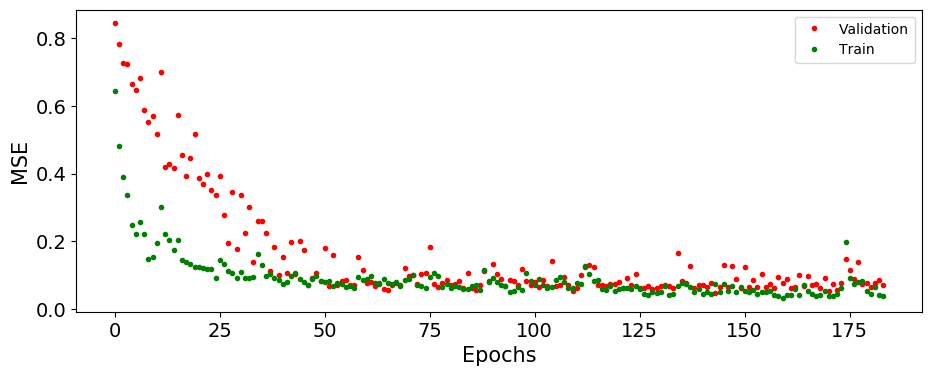

In [37]:
import matplotlib.pyplot as plt
a=np.linspace(1,epoch,epoch)
plt.figure(figsize=(24,4), dpi=100)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'],'r.',label = 'Validation')
plt.plot(history.history['loss'],'g.',label = 'Train')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(loc='upper right')

## Datos de test.

In [38]:
Xm = trainX
ym = trainY
test = x_test
Xtest = Xm[test]
ytest = ym[test]

### Metricas de desmpeño.

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
y_pred = model.predict(Xtest)
y_true = ytest

In [41]:
RMSE = np.sqrt(MSE(y_true, y_pred))
print('RMSE: ',RMSE)

RMSE:  0.21037574


In [42]:
print('MAE: ', MAE(y_true, y_pred))

MAE:  0.05741057


In [43]:
print('MSE: ',MSE(y_pred,y_true))

MSE:  0.044257954


In [44]:
SKILL = 1-np.sqrt(MSE(y_pred,y_true)/np.add.reduce(y_pred*y_pred,None))
print('SKILL: ',SKILL*100)

SKILL:  99.24484589137137


In [45]:
Xtest.shape[0]

36

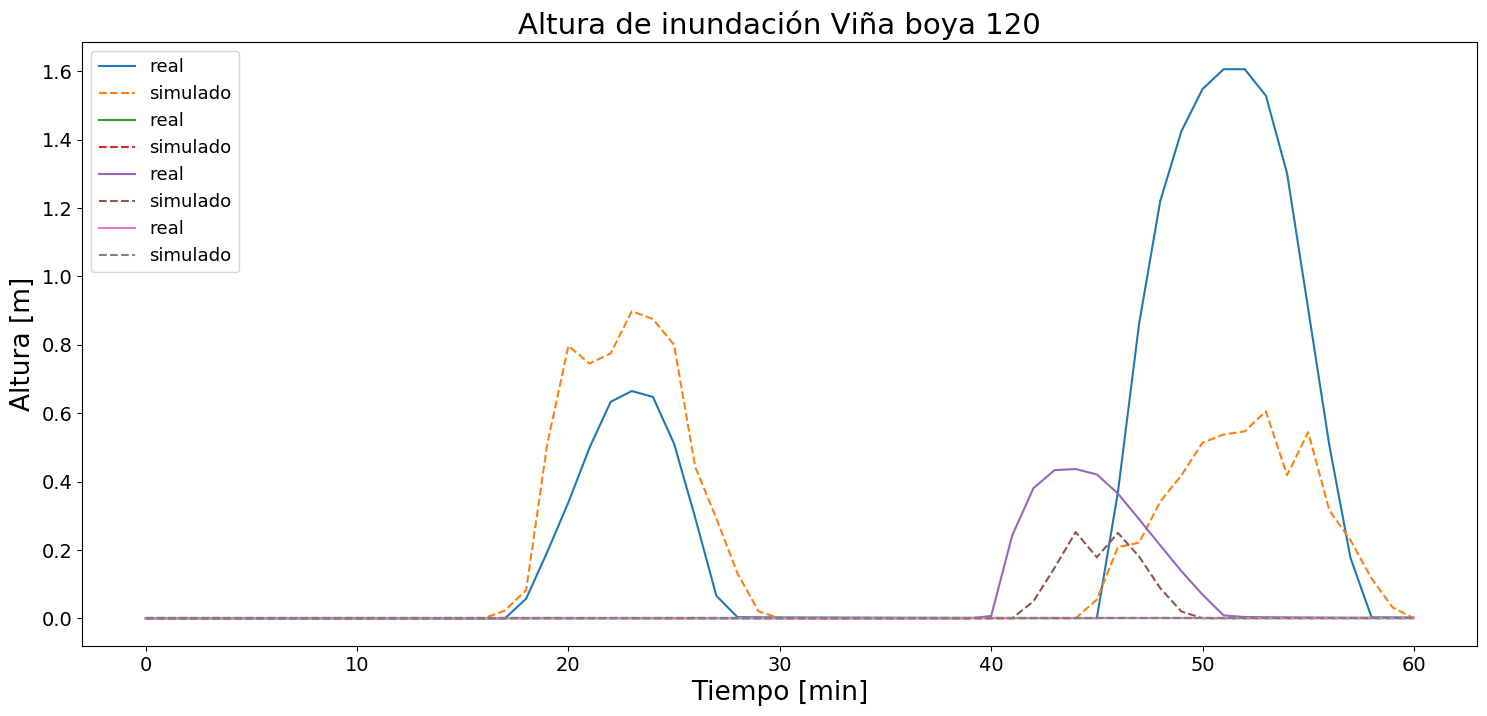

In [46]:
plt.figure(figsize=(18,8), dpi=100)

for i in [1,8,18,27] :
#for i in range(int(Xtest.shape[0]/4)) :
    #plt.figure(figsize=(18,8), dpi=100)
    x_test=Xtest[i].reshape((1,n_steps,1))
    testPredict = (model.predict(x_test)).reshape(-1,1)
    plt.plot(ytest[i],label = 'real')
    plt.plot(testPredict,'--', label = 'simulado')
    #plt.plot(testY,label = 'real test')
    #plt.plot(testPredict, label = 'simulado test')
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17)
    plt.title('Altura de inundación Viña boya 120',fontsize=21)
    plt.ylabel('Altura [m]',fontsize=19)
    plt.xlabel('Tiempo [min]',fontsize=19)
    plt.legend(loc='upper left',fontsize=13)
    #testX=testX.reshape((1,n_steps,1))

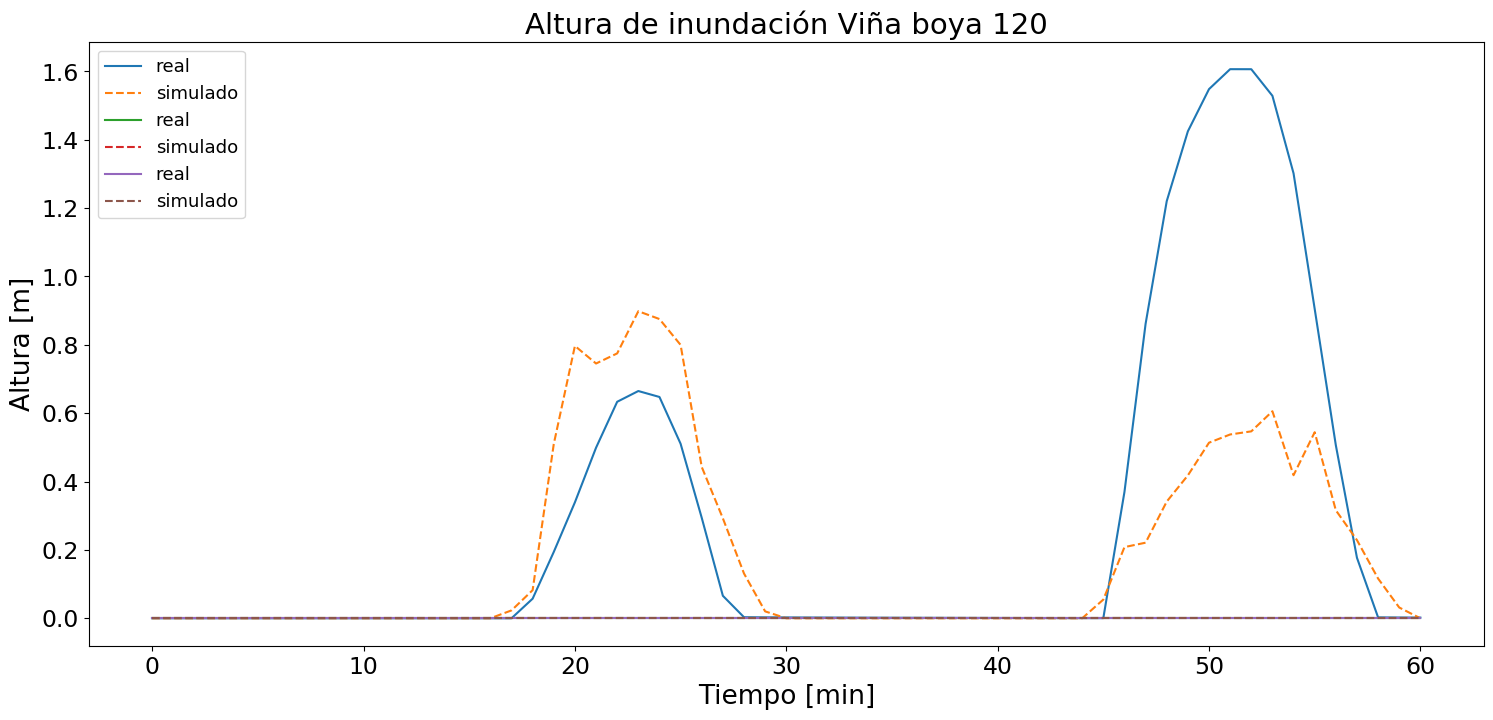

In [47]:
plt.figure(figsize=(18,8), dpi=100)

for i in [1,10,21] :
#for i in range(int(Xtest.shape[0]/4)) :
    #plt.figure(figsize=(18,8), dpi=100)
    x_test=Xtest[i].reshape((1,n_steps,1))
    testPredict = (model.predict(x_test)).reshape(-1,1)
    plt.plot(ytest[i],label = 'real')
    plt.plot(testPredict,'--', label = 'simulado')
    #plt.plot(testY,label = 'real test')
    #plt.plot(testPredict, label = 'simulado test')
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17)
    plt.title('Altura de inundación Viña boya 120',fontsize=21)
    plt.ylabel('Altura [m]',fontsize=19)
    plt.xlabel('Tiempo [min]',fontsize=19)
    plt.legend(loc='upper left',fontsize=13)
    #testX=testX.reshape((1,n_steps,1))

- buscar metrica que penalice mas el error de los maximos.
- buscar split que realice una separacion mas balanceada.
- probar modelo convolucional 1D. con atencion.
- transfer learning con autoencoder.
- capa attention en lstm